
<h1>Data requirements :</h1>

Geographical coordinates(latitide and longitude) to find our where exactly it is located.

To access location of a attractions, its Latitude and Longitude is to be known so that we can point at its coordinates and create a map displaying all the attractions with its labels respectively.<br>

<h3> Initial Data </h3>
Taken the longitutes and latitudes from the gogle map and prepared the dataset.
The data set contains Place with its Latitudes and Longitutes.
The Population in that area and the average income of the people surrunding the area.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import folium 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [33]:
df=pd.read_excel("Data/Part1.xlsx",index_col=0)

In [34]:
df['Borough']=df.index

In [35]:
df.reset_index(drop=True,inplace=True)

In [36]:
df['Latitude']=df['Latitude'].str.strip()
df['Longitude']=df['Longitude'].str.strip()

In [37]:
df['Latitude']=df['Latitude'].astype('float')
df['Longitude']=df['Longitude'].astype('float')

In [39]:
unique_boroughs_of_Chennai = df['Borough'].unique().tolist()
borough_colors ={}
for i in unique_boroughs_of_Chennai:
    borough_colors[i] = '#%02X%02X%02X' % tuple(np.random.choice(range(256),size=3))


In [41]:
chennai_latitude = df['Latitude'].astype('float').mean()
chennai_longitude = df['Longitude'].astype('float').mean()


In [42]:
Chennai_map = folium.Map(location=[chennai_latitude,chennai_longitude],zoom_start=12,control_scale=True)

In [45]:
for lat,lng,boro,nei in zip(df['Latitude'],
                           df['Longitude'],
                           df['Borough'],
                           df['Neighborhoods']):
    label_text = str(boro) + ' - ' + str(nei)
    label = folium.Popup(label_text,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    tooltip = label_text,
    radius = 4,
    popup = label,
    color=borough_colors[boro],
    fill=True,
    fill_color = borough_colors[boro],
    fill_opacity=0.7).add_to(Chennai_map)

<h3>Exploring Neighborhoods using FourSquare API</h3>


In [52]:
CLIENT_ID = 'CQXS3MAKCWX0DIMA1SBERK50VYMI3OXMAVDMGW4XVI5ZAW4N' # your Foursquare ID
CLIENT_SECRET = 'VSH03ZX0SPCCBUXCS1350EWHAAKZDX2ITCQ1KRCVU1GB0534' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=150

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CQXS3MAKCWX0DIMA1SBERK50VYMI3OXMAVDMGW4XVI5ZAW4N
CLIENT_SECRET:VSH03ZX0SPCCBUXCS1350EWHAAKZDX2ITCQ1KRCVU1GB0534


In [53]:
def getNearbyVenues(names, boro, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, boro, lat, lng in zip(names, boro, latitudes, longitudes):
        print("Fetching venues for : ",name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            boro,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [54]:

Chennai_venues = getNearbyVenues(names=df['Neighborhoods'],latitudes=df['Latitude'],longitudes=df['Longitude'],boro=df['Borough'])

Fetching venues for :   Adyar Bus Debot.
Fetching venues for :   Adyar Signal
Fetching venues for :   Alandur
Fetching venues for :   Ambattur
Fetching venues for :   Anna Arch
Fetching venues for :   Anna Nagar Roundana
Fetching venues for :   Anna Nagar West Terminus
Fetching venues for :   Anna Statue
Fetching venues for :   Anna University Entrance
Fetching venues for :   Avadi
Fetching venues for :   AVM Studio
Fetching venues for :   Ayyappa Temple
Fetching venues for :   Basin Bridge
Fetching venues for :   Chennai Airport
Fetching venues for :   Chennai Central
Fetching venues for :   Chennai Mofussil Bus Terminas (CMBT)
Fetching venues for :   Chennai Trade Center
Fetching venues for :   Chepaukam Stadium
Fetching venues for :   chetput
Fetching venues for :   Chintadripet
Fetching venues for :   Chintamani Signal
Fetching venues for :   Chola
Fetching venues for :   Church Park
Fetching venues for :   CIPET
Fetching venues for :   CIT Nagar Roundana
Fetching venues for :   CL

In [55]:
Chennai_venues.head(5)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anna Arch,2,13.0428,80.1306,les Croissants,13.039185,80.131532,Bakery
1,Anna Arch,2,13.0428,80.1306,Aiyanar Bhavan Veg Hotel,13.040989,80.127192,Indian Restaurant
2,Anna Arch,2,13.0428,80.1306,Pizza Corner,13.045141,80.133925,Pizza Place
3,Anna Arch,2,13.0428,80.1306,Akshaya Bhavan,13.039774,80.132018,Indian Restaurant
4,Anna Nagar Roundana,4,13.0504,80.1305,The Colloseum,13.050660,80.131263,Sports Club


In [56]:
individual_chennai_venue_count = Chennai_venues.groupby(['Borough','Neighborhood'])['Borough'].count().to_frame()

In [58]:
individual_chennai_venue_count.rename(columns={'Borough':'NumberOfVenues'},inplace=True)
individual_chennai_venue_count.reset_index(inplace=True)
individual_chennai_venue_count.head()

,Borough,Neighborhood,NumberOfVenues
0,1,Chintamani Signal,2
1,1,Chola,2
2,1,Egmore Railway Station,1
3,1,HTL Colony,1
4,1,Kamarajar Arangam,2


<h3> Data Preprocessing</h3>
<h4>One-Hot Encoding</h4>

In [59]:
Chennai_venues_onehot = pd.get_dummies(Chennai_venues[['Venue Category']])

In [60]:
Chennai_venues_onehot['Neighborhood'] = Chennai_venues['Neighborhood']
Chennai_venues_grouped = Chennai_venues_onehot.groupby('Neighborhood').mean().reset_index()

,Neighborhood,Venue Category_ATM,Venue Category_Afghan Restaurant,Venue Category_Asian Restaurant,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Bike Rental / Bike Share,Venue Category_Buffet,Venue Category_Bus Station,...,Venue Category_Seafood Restaurant,Venue Category_Shopping Mall,Venue Category_Shopping Plaza,Venue Category_Sporting Goods Shop,Venue Category_Sports Club,Venue Category_Supermarket,Venue Category_Tea Room,Venue Category_Track,Venue Category_Travel & Transport,Venue Category_Vegetarian / Vegan Restaurant
0,Anna Arch,0.000000,0.0,0.00,0.250000,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000
1,Anna Nagar Roundana,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.00,1.0,0.000000,0.0,0.0,0.0,0.000000
2,Anna Nagar West Terminus,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000
3,Anna Statue,0.000000,0.0,0.00,0.000000,0.000000,0.25,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000
4,Ayyappa Temple,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000
5,Basin Bridge,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000
6,CIT Nagar Roundana,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.000000,0.500000,0.00,0.0,0.250000,0.0,0.0,0.0,0.000000
7,CLRI,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000
8,Chennai Central,0.400000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.2,0.0,0.000000
9,Chennai Mofussil Bus Terminas (CMBT),0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000


In [65]:
def return_most_common_venues(row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

In [66]:
number_of_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(number_of_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Chennai_venues_grouped['Neighborhood']

for ind in np.arange(Chennai_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Chennai_venues_grouped.iloc[ind, :], number_of_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anna Arch,Cluster,Venue Category_Indian Restaurant,Venue Category_Pizza Place,Venue Category_Bakery,Venue Category_Food Service,Venue Category_Food Court,Venue Category_Food & Drink Shop,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Farm
1,Anna Nagar Roundana,Cluster,Venue Category_Sports Club,Venue Category_Clothing Store,Venue Category_Food Service,Venue Category_Food Court,Venue Category_Food & Drink Shop,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Farm,Venue Category_Electronics Store
2,Anna Nagar West Terminus,Cluster,Venue Category_Indian Restaurant,Venue Category_Coffee Shop,Venue Category_Food Service,Venue Category_Food Court,Venue Category_Food & Drink Shop,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Farm,Venue Category_Electronics Store
3,Anna Statue,Cluster,Venue Category_Bar,Venue Category_Hotel,Venue Category_Electronics Store,Venue Category_Clothing Store,Venue Category_Bank,Venue Category_Bakery,Venue Category_Food Service,Venue Category_Afghan Restaurant,Venue Category_Food Court
4,Ayyappa Temple,Cluster,Venue Category_Café,Venue Category_Pharmacy,Venue Category_Coffee Shop,Venue Category_Food Service,Venue Category_Food Court,Venue Category_Food & Drink Shop,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Farm


<h3>Clustering</h3>

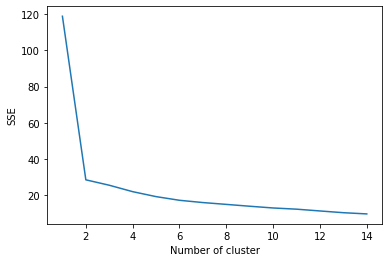

In [74]:
sse = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(Chennai_venues_grouped.drop('Neighborhood',axis=1))
    Chennai_venues_grouped['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [75]:
kmeans = KMeans(n_clusters=2,random_state=0)
kmeans.fit(Chennai_venues_grouped.drop('Neighborhood',axis=1))


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [76]:
Chennai_venues_grouped['Cluster'] = kmeans.labels_


In [77]:
Chennai_venues_grouped.groupby('Cluster')['Neighborhood'].count()


Cluster
0    21
1    46
Name: Neighborhood, dtype: int64

In [78]:

neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(Chennai_venues_grouped,on='Neighborhood')

In [79]:
neighborhoods_venues_sorted.columns
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(Chennai_venues,on='Neighborhood')


In [80]:
# create map
map_clusters = folium.Map(location=[chennai_latitude, chennai_longitude], zoom_start=11)

In [87]:
# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Neighborhood Latitude_y'], neighborhoods_venues_sorted['Neighborhood Longitude_y'], neighborhoods_venues_sorted['Neighborhood'], neighborhoods_venues_sorted['Cluster_y']):
    label = folium.Popup(str(poi) +' Cluster'+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [88]:
map_clusters

In [91]:
#Recommendations
Near_ATM = Chennai_venues_onehot.groupby(['Neighborhood']).sum().reset_index()
Near_ATM = Chennai_venues_onehot[['Neighborhood','Venue Category_ATM']]


In [95]:
#Sample Recommendations

results = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood']=='Anna Arch']